# Trivial hyperspectral image classification with a graph neural network
#### Ciaran Bench
There is a strong desire among spectroscopists to exploit the chemical/compositional information encoded in a tissue's hyperspectral image (HSI) (an image that can be formed by collating Raman or IR spectra acquired at equally spaced-out points across a sample) to predict its pathology state well before more obvious morphological signs used by pathologists become visible at later stages of the disease's progression. 

Though, the high dimensionality of HSIs demand models with a large number of parameters to manipulate whole images. These require extensive training sets to optimise, which are time-consuming and expensive to acquire. Often patch-based strategies are implemented to make training more computationally tractable. However, these often fail to take into account long-range spatio-spectral features that may be critical to identifying the sample's pathology state.

We discuss the possibility of using a CAE-based feature extraction framework to convert whole HSIs into graph structures, making them amenable to processing with lightweight graph neural networks. This scheme enables the detection of long-range spatial dependencies using fewer parameters than generic convolutional networks applied to whole HSIs. This may ultimately reduce the amount of labelled training data required to learn an accurate classification model.

We test our approach on a trivial toy problem, mostly to demonstrate how this strategy can be implemented as opposed to exhibiting a scenario where it may outperform more generic architectures.

Much of the GNN code is inspired by that used in this tutorial (https://dmol.pub/dl/gnn.html) by Andrew White. 

## Introduction
### Graph construction workflow


In principle, 'unprocessed' hyperspectral images can be treated as graphs, where each pixel is a node, whose features are described by ther consituent spectra. However, the resultant graph would be very large, and the node-level features (described shortly) would be high dimensional. This makes the learning process inefficient, additionally requiring a large dataset to train the model (i.e. we suffer from similar problems that we encounter when trying to use CNNs to process whole HSI data).

So how can we capture the information encoded in an image into a more 'lightweight' graph structure? Essentially, we need some way to compress information about the features contained in each region, while retaining information about where in the image these features reside in. 

Here, this is achieved in a completely unsupervised fashion using a convolutional autoencoder (CAE).

First, a generic 2D CAE is trained to compress $10\times10\times100$ non-overlapping image patches parsed from 30 synthetic HSIs with dimensions $100\times100\times100$. 

Then, graph construction for a given HSI is performed by: 

a) decomposing it into non-overlapping $10\times10\times100$ patches, 

b) individually passing each patch through the pretrained CAE, 

c) constructing a $10\times10$ grid-graph where each patch in the original image is converted into a node defined by the patch's 20 element latent vector acquired in b).


These graphs are then fed into our GNN for classification.


Therefore, each HSI is represented by a $10\times10$ grid-graph, where each node is defined by their respective patch's latent vector. Aggregation of similar nodes should be performed to further reduce the representation of larger HSIs, though here the grid structure is retained for simplicity. Therefore in this specific case, a CNN could be used instead of a GNN, but it may be less applicable when graphs are aggregated in real scenarios.

## Further details: Autoencoders, graphs, and GNNs
The next few text blocks define the components of the architecture in a bit more detail. Skip ahead to the 'Training and data' section if you are already familair with autoencoders, graphs, and GNNs.

### Autoencoder 

The autoencoder consists of two components: 1) an encoder $A_E$ that learns a mapping from an input HSI patch $x_i \in X$ to a set of low-dimensional latent vectors $l_{i} \in L, A_{E}: X \rightarrow L$ were i indexes each patch and 2) a decoder $A_D$ that learns a mapping from the input patch's set of latent vectors $l_{i}$ to a reconstruction of the original input $\hat{x}$, $A_{D}: L \rightarrow \hat{X}$.

Once trained, the set of latent vectors associated with each input image patch will encode information that enables the decoder to perform the reconstruction. This should consist of information about the spatial and spectral features contained in each patch.

Therefore, this network can be thought of as a 'feature miner'. 

### Graphs

A graph $G = (V,E)$ is given by a set of vertices/nodes ($V$) and edges ($E$). Vertices are entities that have their own descriptive features (here, called node features), and have relationships to other vertices in the graph. In a set of all vertices $V$, each vertex is indexed with $i$, $v_{i} \in V$. Edges represent the relationship/connectivity between each vertex and all others in the graph. In the set of all edges $E$, the edge between vertices $i$ and $j$ is written as $e_{i,j} \in E$. Here, $e_{i,j} = 1$ if $i$ and $j$ and connected, otherwise, the value is $0$. 

Both vertices and edges may be characterised by features. E.g. in a social network, each vertex may represent a user, where a feature vector encodes their personal data, such as age and gender. This vector is sometimes called a node feature. Similarly, edges may be defined by edge features that encode information about the connectivity between two vertices, such as how likely each user will know eachother. 

Some graphs are directed, meaning the connectivity between nodes has some direction. Also, the types of nodes/edges in a single graph can sometimes vary.

The graphs used here are rather simple - they are a) homogeneous (all nodes and edges are of the same type), and b) they are unweighted meaning edges simply encode whether nodes are connected and contain no further information such as notions of 'distance' or other features (our graph is constructed from equally spaced out points, so there is no need to define edge features). Though, if these grid-graphs are aggregated (removing their grid structure), then distances between nodes would become relevant, and the resulting graph should ideally have edge features.

Here, a graph is represented by its adjacency matrix which encodes information about the connectivity of each node. For a graph with $n$ nodes, the adjacency matrix may be constructed from an $n\times n$ matrix where each element describes the connectivity between nodes. E.g. if node 1 and 3 are connected, then $A(1,3) = 1$, and $A(3,1) = 1$ . Node distance or other features may be used instead of $1$ or $0$.

Further details can be found in the turorial listed at the end of this text block. 

## Graph neural networks 

#### Graph convolutional layers
The architecture used here features several graph convolutional layers. In our case, these will output an 'updated' version of the graph, where a node's feature vector is 'replaced' with a weighted average of the features of its neighbouring nodes. The network learns weights that enable the detection of useful features (i.e. information about the kinds of features that reside in a particular location in the graph with respect to a given node). 

Specifically, the graph convolution used here performs the following operation (expressed in Einstein notation):

$v_{il}=\sigma(\frac{1}{d_i}e_{ij}v_{jk}w_{lk})$,

"where $i$ is the node, $j$ is its neighbour, $k$ is the node's feature, $l$ is the output node feature, $d_i$ is the degree of node $i$ (which makes it an average instead of sum), $e_{ij}$ isolates neighbors so that all non-neighbor $v_{jk}$s are zero, $\sigma$ is our activation, and $w_{lk}$ are the trainable weights". 

Chaining GCN layers allows for hierarchical feature extraction. The output of the first layer for a given node only encodes information about immediately neighbouring nodes ('1st order' neighbours). However, this process is also applied to neighbouring nodes, meaning that the 1st order neighbours of a node in the updated graph encode information about the node's 2nd order neighbours. Therefore, the second GCN layer will detect features encoding information about a larger portion of the graph.

#### Graph level feature
Once GCN layers have extracted features, these are summarised into a single 'graph-level' feature to use as an input to feed forward layers for classification. Here, a simple average over all node features is used to acquire a graph-level feature. 


#### Resources
A Practical Tutorial on Graph Neural Networks
Isaac Ronald Ward, Jack Joyner, Casey Lickfold, Yulan Guo, Mohammed Bennamoun 
https://arxiv.org/abs/2010.05234

Graph Neural Networks
Andrew White
https://dmol.pub/dl/gnn.html

# Training data


To demonstrate how unsupervised CAE-based graph construction could be implemented, we consider a trivial toy problem where we aim to classify two types of synthetic tissue samples depicted as $100\times100\times100$ Raman HSIs - one sample type always composed of a piece of porcine fat with three conjoined components immersed in muscle, and one always composed of a single body of fat immersed in muscle. I attempted to produce samples that may be classified by considering the long and short range spatial distribution of their spatio-sepctral features. Therefore, each sample should be indistinguishable when observed at the patch level. 

Here are the spectra used to construct each HSI. All fat pixels contain a spectrum composed of the first 100 measurments of the this measured fat spectrum, while the spectra for all muscle pixels are composed of the first 100 measurments of the this measured muscle spectrum.

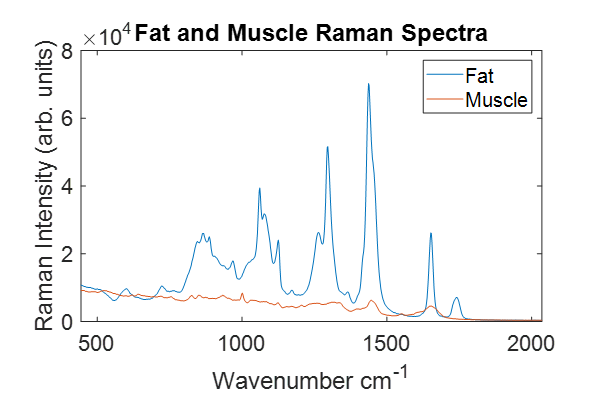

200 HSIs not used to train the CAE were converted into graphs, and then split into training, validation, and test sets.




## Example images

The yellow region is fat, while the blue region is muscle. Each fat body has varying scale and morphology.

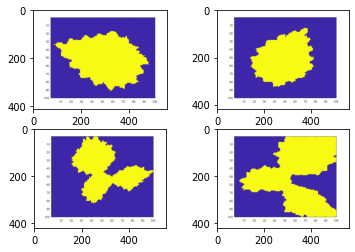

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread('ex2.png'))
axarr[0,1].imshow(mpimg.imread('ex1.png'))
axarr[1,0].imshow(mpimg.imread('ex3.png'))
axarr[1,1].imshow(mpimg.imread('ex4.png'))

### Load in the datsets (pregenerated and preprocessed in MATLAB)
These datasets are 10x10 patches parsed from various HSIs.

In [2]:
import numpy as np
import scipy.io
import mat73

train_set = mat73.loadmat('train_set_parsed.mat')
train_set = train_set['train_set_parsed']
train_set = train_set[0:10000,:,:,:]
print(np.shape(train_set))

vali_set = mat73.loadmat('vali_set_parsed.mat')
vali_set = vali_set['vali_set_parsed']

test_set = mat73.loadmat('test_set_parsed.mat')
test_set = test_set['test_set_parsed']

(6000, 10, 10, 100)


## Training the autoencoder

### Define the autoencoder graph

In [3]:
import sys
#!{sys.executable} -m pip install mat73
import keras
from keras import layers
import numpy as np
#from keras.optimizer_v2.adam import Adam as Adam
input_img = keras.Input(shape=(10, 10, 100))

x = layers.Conv2D(50, (3, 3), activation='relu', padding='same')(input_img)
x = layers.Conv2D(50, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(20, activation='relu')(x)
encoder = keras.Model(input_img, encoded)
x = layers.Dense(400, activation='relu')(encoded)
x = layers.Reshape((10,10,4))(x)
x = layers.Conv2D(50, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(50, (3, 3), activation='relu', padding='same')(x)
decoded = layers.Conv2D(100, (3, 3), activation='relu', padding='same')(x)

#opt = Adam(learning_rate=0.01)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')#binary_crossentropy

### Train the autoencoder

In [4]:
autoencoder.fit(train_set, train_set,
                epochs=60,
                batch_size=256,
                shuffle=True,
                validation_data=(vali_set, vali_set))

Epoch 1/60
24/24 [==============================] - 7s 268ms/step - loss: 0.1060 - val_loss: 0.0438
Epoch 2/60
24/24 [==============================] - 4s 157ms/step - loss: 0.0335 - val_loss: 0.0250
Epoch 3/60
24/24 [==============================] - 4s 168ms/step - loss: 0.0205 - val_loss: 0.0157
Epoch 4/60
24/24 [==============================] - 4s 156ms/step - loss: 0.0139 - val_loss: 0.0122
Epoch 5/60
24/24 [==============================] - 3s 146ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 6/60
24/24 [==============================] - 3s 145ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 7/60
24/24 [==============================] - 4s 166ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 8/60
24/24 [==============================] - 4s 147ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 9/60
24/24 [==============================] - 3s 143ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 10/60
24/24 [==============================] - 3s 146ms/step - loss: 0.0071 - val_loss: 0.0068

# Graph construction
Here, we extract the node features for our images by feeding their constituent patches into the pretrained autencoder, and acquiring their respective latent vectors. 

In [5]:

encoded_imgs = np.zeros((np.shape(test_set)[0],100,20))
for i in range(0,np.shape(test_set)[0]):
    test_set_ex = np.squeeze(test_set[i,:,:,:,:])
    net_output = encoder.predict(test_set_ex)
    encoded_imgs[i,:,:] = net_output
    recons = autoencoder.predict(test_set_ex)

mdic = {"encoded_imgs": encoded_imgs}
scipy.io.savemat("encoded_imgs.mat", mdic)

mdic = {"recons": recons}
scipy.io.savemat("recons.mat", mdic)

### Now we construct a graph for each image using these latent vectors.

In [6]:
import networkx as nx

import numpy as np
all_graphs = []
for graph_num in range(0,np.shape(encoded_imgs)[0]):
    encoded_imgs_ex = np.squeeze(encoded_imgs[graph_num,:,:])
    G = nx.grid_graph(dim=[10,10])
    counter = 0
    for i in range(0,10):
        for j in range(0,10):
            nx.set_node_attributes(G, {(i,j): {"latent": np.squeeze(encoded_imgs_ex[counter])}})
            counter = counter+1
    all_graphs.append(G)

#### Visualise the latent vectors for each patch parsed from a single image. There should be some variablity in the values, as many patches will have distinct features. 

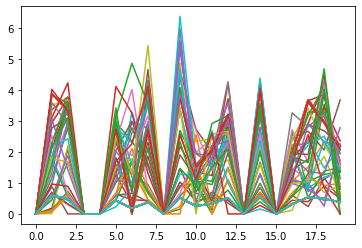

In [7]:
arr=[]
from matplotlib import pyplot as plt

G = all_graphs[50]
for i in range(0,10):
    for j in range(0,10):
        plt.plot(G.nodes[i,j]["latent"]) 
plt.show()

# Defining our GNN Classifier
    

## Define data generator
This is a function that returns multiple items. This allows us to structure our dataset (where each example is composed of several items) in a way that makes it easy to parse into train/vali/test sets. 

In [8]:
test_truths = scipy.io.loadmat('test_truths.mat')
test_truths = test_truths['test_truths']

In [9]:
np.shape(encoded_imgs)

(301, 100, 20)

In [10]:
np.shape(test_truths)

(301, 2)

In [11]:

import tensorflow as tf
def example():
    for i in range(len(all_graphs)):
        nodes_enc = []
        g = all_graphs[i]
        for j in range(0,10):
            for k in range(0,10):
                nodes_enc.append(g.nodes[j,k]["latent"])
        nodes = nodes_enc
        classif = test_truths[i] 
        
        g_adj = nx.to_numpy_array(g)
        adj_mat = g_adj#csr_matrix(g_adj).toarray()
        adj_mat = adj_mat.astype(np.float)
        graph = (nodes, adj_mat)
        yield graph, classif

data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, 20]), tf.TensorShape([None, None])),
        tf.TensorShape([2]),
    ),
)

#### The network outputs the updated node features and the adjacency matrix. The adjacency matrix is output so that multiple GCN layers can be stacked in a straighforward manner without having to pass the adjacency matrix each time.

## Define a custom GCN layer using the layer subclass.

In [12]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation 
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

## Define the GCN graph

In [13]:
# define node feature input

ninput = tf.keras.Input(
    (
        None,
        20,
    )
)
# define adjacency matrix input
ainput = tf.keras.Input(
    (
        None,
        None,
    )
)
# GCN block
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
# reduce to graph level feature
x = GRLayer()(x)
# standard layers (the readout)
x = tf.keras.layers.Dense(20,"relu")(x)
#x = tf.keras.layers.Dense(20,"relu")(x)
x = tf.keras.layers.Dense(10,"relu")(x)
x = tf.keras.layers.Dense(2, "softmax")(x)

model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 20)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
gcn_layer (GCNLayer)            ((None, None, 20), ( 400         input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
gcn_layer_1 (GCNLayer)          ((None, None, 20), ( 400         gcn_layer[0][0]            

# Train GCN classifier

## Split data

In [14]:
test_data = data.take(50)
val_data = data.skip(50).take(50)
train_data = data.skip(100)

checkpoint_filepath = './checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
    )

#optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = 'adam', loss="mean_squared_error")#binary_crossentropy mean_squared_error
result = model.fit(
    train_data.batch(1), batch_size = 1, epochs=150,validation_data=val_data.batch(1),callbacks=[model_checkpoint_callback]
)

Epoch 1/150
     31/Unknown - 1s 3ms/step - loss: 0.2495

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 2s 5ms/step - loss: 0.2510 - val_loss: 0.2524
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 2/150
 39/201 [====>.........................] - ETA: 0s - loss: 0.2406

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.2487 - val_loss: 0.2493
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 3/150
 34/201 [====>.........................] - ETA: 0s - loss: 0.2380

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.2488 - val_loss: 0.2510
Epoch 4/150
201/201 [==============================] - 1s 5ms/step - loss: 0.2482 - val_loss: 0.2489
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 5/150
 41/201 [=====>........................] - ETA: 0s - loss: 0.2409

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.2451 - val_loss: 0.2494
Epoch 6/150
201/201 [==============================] - 1s 4ms/step - loss: 0.2444 - val_loss: 0.2495
Epoch 7/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2443 - val_loss: 0.2502
Epoch 8/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2448 - val_loss: 0.2499
Epoch 9/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2442 - val_loss: 0.2498
Epoch 10/150
201/201 [==============================] - ETA: 0s - loss: 0.245 - 1s 4ms/step - loss: 0.2439 - val_loss: 0.2505
Epoch 11/150
201/201 [==============================] - 1s 4ms/step - loss: 0.2440 - val_loss: 0.2494
Epoch 12/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2446 - val_loss: 0.2523
Epoch 13/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2469 - val_loss: 0.2504
Epoch 14/150
201/201 [==============================] - 1s 3ms/step - loss:

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.2441 - val_loss: 0.2497
Epoch 22/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2448 - val_loss: 0.2492
Epoch 23/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2442 - val_loss: 0.2483
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 24/150
 42/201 [=====>........................] - ETA: 0s - loss: 0.2323

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.2442 - val_loss: 0.2491
Epoch 25/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2434 - val_loss: 0.2482
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 26/150
 44/201 [=====>........................] - ETA: 0s - loss: 0.2283

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.2422 - val_loss: 0.2556
Epoch 27/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2468 - val_loss: 0.2520
Epoch 28/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2405 - val_loss: 0.2566
Epoch 29/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2435 - val_loss: 0.2391
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 30/150
 44/201 [=====>........................] - ETA: 0s - loss: 0.2103

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.2382 - val_loss: 0.2474
Epoch 31/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2393 - val_loss: 0.2296
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 32/150
 44/201 [=====>........................] - ETA: 0s - loss: 0.1801

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.2330 - val_loss: 0.2307
Epoch 33/150
201/201 [==============================] - 1s 3ms/step - loss: 0.2175 - val_loss: 0.2160
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 34/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.1655

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1948 - val_loss: 0.1933
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 35/150
 37/201 [====>.........................] - ETA: 0s - loss: 0.1369

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1839 - val_loss: 0.1939
Epoch 36/150
201/201 [==============================] - 1s 3ms/step - loss: 0.1811 - val_loss: 0.2126
Epoch 37/150
201/201 [==============================] - 1s 3ms/step - loss: 0.1717 - val_loss: 0.1781
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 38/150
 40/201 [====>.........................] - ETA: 0s - loss: 0.1152

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1633 - val_loss: 0.1777
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 39/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.1080

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1681 - val_loss: 0.2004
Epoch 40/150
201/201 [==============================] - 1s 3ms/step - loss: 0.1583 - val_loss: 0.1705
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 41/150
 37/201 [====>.........................] - ETA: 0s - loss: 0.0941

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.1491 - val_loss: 0.1653
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 42/150
 44/201 [=====>........................] - ETA: 0s - loss: 0.0959

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1442 - val_loss: 0.1617
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 43/150
 43/201 [=====>........................] - ETA: 0s - loss: 0.0961

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1353 - val_loss: 0.1798
Epoch 44/150
201/201 [==============================] - 1s 3ms/step - loss: 0.1300 - val_loss: 0.1759
Epoch 45/150
201/201 [==============================] - 1s 3ms/step - loss: 0.1297 - val_loss: 0.1627
Epoch 46/150
201/201 [==============================] - 1s 3ms/step - loss: 0.1217 - val_loss: 0.1751
Epoch 47/150
201/201 [==============================] - 1s 3ms/step - loss: 0.1170 - val_loss: 0.1598
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 48/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0873

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1132 - val_loss: 0.1382
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 49/150
 44/201 [=====>........................] - ETA: 0s - loss: 0.0762

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1065 - val_loss: 0.1226
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 50/150
 44/201 [=====>........................] - ETA: 0s - loss: 0.0707

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.1063 - val_loss: 0.1166
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 51/150
 43/201 [=====>........................] - ETA: 0s - loss: 0.0689

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.0993 - val_loss: 0.0842
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 52/150
 41/201 [=====>........................] - ETA: 0s - loss: 0.0612

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.0889 - val_loss: 0.0718
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 53/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0521

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0852 - val_loss: 0.0669
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 54/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0544

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.0764 - val_loss: 0.0992
Epoch 55/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0762 - val_loss: 0.0540
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 56/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0443

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0614 - val_loss: 0.0450
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 57/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0262

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0560 - val_loss: 0.0422
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 58/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0341

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0454 - val_loss: 0.0372
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 59/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0257

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0422 - val_loss: 0.0340
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 60/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0189

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0330 - val_loss: 0.0246
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 61/150
 46/201 [=====>........................] - ETA: 0s - loss: 0.0182

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0268 - val_loss: 0.0241
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 62/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0168

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0248 - val_loss: 0.0236
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 63/150
 45/201 [=====>........................] - ETA: 0s - loss: 0.0148

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0214
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 64/150
 40/201 [====>.........................] - ETA: 0s - loss: 0.0073

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0207 - val_loss: 0.0242
Epoch 65/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0295 - val_loss: 0.0197
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 66/150
 41/201 [=====>........................] - ETA: 0s - loss: 0.0086

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0229 - val_loss: 0.0235
Epoch 67/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0283 - val_loss: 0.0227
Epoch 68/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0217 - val_loss: 0.0112
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 69/150
 12/201 [>.............................] - ETA: 0s - loss: 0.0029 

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.0163 - val_loss: 0.0207
Epoch 70/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0338 - val_loss: 0.0216
Epoch 71/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0262 - val_loss: 0.0209
Epoch 72/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0276 - val_loss: 0.0364
Epoch 73/150
201/201 [==============================] - 1s 5ms/step - loss: 0.0243 - val_loss: 0.0229
Epoch 74/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0510 - val_loss: 0.4006
Epoch 75/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0552 - val_loss: 0.0356
Epoch 76/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0221 - val_loss: 0.0195
Epoch 77/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.1213
Epoch 78/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0450 - val_loss: 

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0091 - val_loss: 0.0593
Epoch 82/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0262 - val_loss: 0.1186
Epoch 83/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0583 - val_loss: 0.0350
Epoch 84/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0155 - val_loss: 0.0038
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 85/150
 37/201 [====>.........................] - ETA: 0s - loss: 0.0017

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.0160 - val_loss: 0.1237
Epoch 86/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0383 - val_loss: 0.0173
Epoch 87/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.2344
Epoch 88/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0272 - val_loss: 0.0029
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 89/150
 43/201 [=====>........................] - ETA: 0s - loss: 0.0158

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0256 - val_loss: 0.1389
Epoch 90/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.1699
Epoch 91/150
201/201 [==============================] - 2s 8ms/step - loss: 0.0241 - val_loss: 0.0044
Epoch 92/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0115 - val_loss: 0.1551
Epoch 93/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0176 - val_loss: 0.0025
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 94/150
 21/201 [==>...........................] - ETA: 0s - loss: 9.2046e-04

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 0.0151 - val_loss: 0.0021
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 95/150
 40/201 [====>.........................] - ETA: 0s - loss: 0.0021    

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 96/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0013
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 97/150
 41/201 [=====>........................] - ETA: 0s - loss: 6.7095e-04

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 7.5304e-04 - val_loss: 0.0017
Epoch 98/150
201/201 [==============================] - 1s 4ms/step - loss: 0.0097 - val_loss: 0.0082
Epoch 99/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0163
Epoch 100/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0444 - val_loss: 0.0016
Epoch 101/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0200 - val_loss: 0.0027
Epoch 102/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0176 - val_loss: 0.0036
Epoch 103/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0177 - val_loss: 0.0564
Epoch 104/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0161 - val_loss: 0.2935
Epoch 105/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0242 - val_loss: 0.0016
Epoch 106/150
201/201 [==============================] - 1s 3ms/step - loss: 0.0019 -

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 2.3398e-04 - val_loss: 0.0011
Epoch 117/150
201/201 [==============================] - 1s 5ms/step - loss: 1.8616e-04 - val_loss: 0.0010
Epoch 118/150
201/201 [==============================] - 1s 7ms/step - loss: 1.5198e-04 - val_loss: 9.6944e-04
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 119/150
 46/201 [=====>........................] - ETA: 0s - loss: 1.1955e-04

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 1.2667e-04 - val_loss: 8.8932e-04
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 120/150
 41/201 [=====>........................] - ETA: 0s - loss: 1.0856e-04

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 1.0645e-04 - val_loss: 8.4516e-04
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 121/150
 18/201 [=>............................] - ETA: 0s - loss: 1.0604e-04 

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 4ms/step - loss: 8.9747e-05 - val_loss: 8.4161e-04
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 122/150
 13/201 [>.............................] - ETA: 0s - loss: 9.8520e-05 

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 6ms/step - loss: 7.5880e-05 - val_loss: 8.7671e-04
Epoch 123/150
201/201 [==============================] - 1s 3ms/step - loss: 6.4515e-05 - val_loss: 8.6614e-04
Epoch 124/150
201/201 [==============================] - 1s 3ms/step - loss: 5.5949e-05 - val_loss: 7.7303e-04
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 125/150
 46/201 [=====>........................] - ETA: 0s - loss: 4.8856e-05

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 4.8420e-05 - val_loss: 7.5443e-04
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 126/150
 46/201 [=====>........................] - ETA: 0s - loss: 4.2694e-05

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 4.2218e-05 - val_loss: 7.4428e-04
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 127/150
 46/201 [=====>........................] - ETA: 0s - loss: 3.7426e-05

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 3.7378e-05 - val_loss: 7.2226e-04
INFO:tensorflow:Assets written to: .\checkpoint\assets
Epoch 128/150
 44/201 [=====>........................] - ETA: 0s - loss: 3.3142e-05

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 3.2929e-05 - val_loss: 7.8138e-04
Epoch 129/150
201/201 [==============================] - 1s 3ms/step - loss: 2.9213e-05 - val_loss: 7.7516e-04
Epoch 130/150
201/201 [==============================] - 1s 3ms/step - loss: 2.5874e-05 - val_loss: 7.7290e-04
Epoch 131/150
201/201 [==============================] - 1s 3ms/step - loss: 2.2815e-05 - val_loss: 7.9586e-04
Epoch 132/150
201/201 [==============================] - 1s 3ms/step - loss: 2.0169e-05 - val_loss: 8.0569e-04
Epoch 133/150
201/201 [==============================] - 1s 3ms/step - loss: 1.7792e-05 - val_loss: 8.2734e-04
Epoch 134/150
201/201 [==============================] - 1s 3ms/step - loss: 1.5657e-05 - val_loss: 8.0822e-04
Epoch 135/150
201/201 [==============================] - 1s 3ms/step - loss: 1.3676e-05 - val_loss: 8.0455e-04
Epoch 136/150
201/201 [==============================] - 1s 3ms/step - loss: 1.1935e-05 - val_loss: 8.4266e-04
Epoch 137/150
2

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


201/201 [==============================] - 1s 3ms/step - loss: 9.8464e-06 - val_loss: 8.5081e-04
Epoch 139/150
201/201 [==============================] - 1s 3ms/step - loss: 8.9298e-06 - val_loss: 8.6481e-04
Epoch 140/150
201/201 [==============================] - 1s 3ms/step - loss: 7.9909e-06 - val_loss: 0.0010
Epoch 141/150
201/201 [==============================] - 1s 3ms/step - loss: 7.2458e-06 - val_loss: 0.0011
Epoch 142/150
201/201 [==============================] - 1s 3ms/step - loss: 6.4355e-06 - val_loss: 0.0011
Epoch 143/150
201/201 [==============================] - 1s 3ms/step - loss: 5.7879e-06 - val_loss: 0.0012
Epoch 144/150
201/201 [==============================] - 1s 3ms/step - loss: 5.1472e-06 - val_loss: 0.0014
Epoch 145/150
201/201 [==============================] - 1s 3ms/step - loss: 4.6100e-06 - val_loss: 0.0015
Epoch 146/150
201/201 [==============================] - 1s 3ms/step - loss: 4.1008e-06 - val_loss: 0.0015
Epoch 147/150
201/201 [====================

## Visualise loss curves

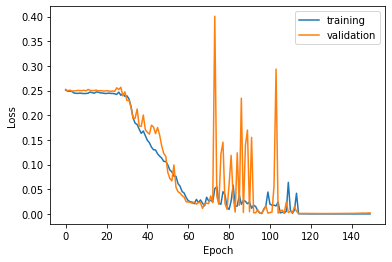

In [15]:
from matplotlib import pyplot as plt

plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluate test set

In [16]:
model.load_weights(checkpoint_filepath)

output = model.predict(test_data.batch(1))

C:\Users\cb1111\AppData\Local\Temp/ipykernel_10540/394017935.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_mat = adj_mat.astype(np.float)


In [18]:
classifier_performance = test_truths[0:50] - np.round(output)
classifier_performance = classifier_performance[:,0]
print('Classification Accuracy:',100*(1-sum(abs(classifier_performance))/len(classifier_performance)),'%')

Classification Accuracy: 100.0 %
